In [1]:
import os
import sys
import numpy as np
import pandas as pd
import pydicom
import matplotlib.pyplot as plt
import collections
from tqdm import tqdm_notebook as tqdm
from datetime import datetime
from typing import Union
import zipfile

from math import ceil, floor, log
import cv2

from tensorflow import keras
from tensorflow.keras import backend as K
from keras_applications.inception_v3 import InceptionV3
import tensorflow as tf

from sklearn.model_selection import ShuffleSplit

2024-11-19 15:17:51.757996: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732029471.778838   69428 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732029471.785513   69428 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-19 15:17:51.808842: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#--------------------- for working with zipfile----------------------------
# ROOT_DATA_PATH='/workspace/datasets/'
# DATASET_PATH=f'{ROOT_DATA_PATH}/rsna-intracranial-hemorrhage-detection.zip'
# TRAIN_DATA_PATH='rsna-intracranial-hemorrhage-detection/stage_2_train'
# TEST_DATA_PATH='rsna-intracranial-hemorrhage-detection/stage_2_test'
# TRAIN_METADATA_PATH='rsna-intracranial-hemorrhage-detection/stage_2_train.csv'
# TEST_METADATA_PATH='rsna-intracranial-hemorrhage-detection/stage_2_sample_submission.csv'

#--------------------- for working with directory ----------------------------
ROOT_DATA_PATH='/workspace/datasets'
DATASET_PATH=f'{ROOT_DATA_PATH}/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection'
TRAIN_DATA_PATH=f'{DATASET_PATH}/stage_2_train'
TEST_DATA_PATH=f'{DATASET_PATH}/stage_2_test'
TRAIN_METADATA_PATH=f'{DATASET_PATH}/stage_2_train.csv'
TEST_METADATA_PATH=f'{DATASET_PATH}/stage_2_sample_submission.csv'

TRAIN_METADATA_SEQ_PATH=f'{ROOT_DATA_PATH}/rsna-intracranial-sequence-metadata/train_metadata_noidx.csv'
TEST_METADATA_SEQ_PATH=f'{ROOT_DATA_PATH}/rsna-intracranial-sequence-metadata/test_metadata_noidx.csv'

In [ ]:
# dataset_handler = zipfile.ZipFile(DATASET_PATH)

In [ ]:
def correct_dcm(dcm: pydicom.FileDataset):
    # x = torch.from_numpy(dcm.pixel_array).cuda()
    x = dcm.pixel_array
    x = x + 1000
    px_mode = 4096
    x[x >= px_mode] = x[x >= px_mode] - px_mode
    # dcm.PixelData = x.cpu().numpy().tobytes()
    dcm.PixelData = x.tobytes()
    dcm.RescaleIntercept = -1000
    
def window_image(dcm: pydicom.FileDataset, window_center: int, window_width: int):
    if (dcm.BitsStored == 12) and (dcm.PixelRepresentation == 0) and (int(dcm.RescaleIntercept) > -100):
        correct_dcm(dcm)
    
    # Pixel to Hounsfield Unit (HU)
    # HU=(Pixel Value×RescaleSlope)+RescaleIntercept
    img = dcm.pixel_array
    img = img * dcm.RescaleSlope + dcm.RescaleIntercept 
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    img = np.clip(img, img_min, img_max)
    
    return img

def get_windowed_image(dcm: pydicom.FileDataset, window: Union['brain', 'subdural', 'soft'] = 'brain') -> np.ndarray: # type: ignore
    im = None
    match window:
        case 'brain':
            brain_img = window_image(dcm, 40, 80)
            brain_img = (brain_img - 0) / 80
            im = brain_img
        case 'subdural':
            subdural_img = window_image(dcm, 80, 200)
            subdural_img = (subdural_img - (-20)) / 200
            im = subdural_img
        case 'soft':
            soft_img = window_image(dcm, 40, 380)
            soft_img = (soft_img - (-150)) / 380
            im = soft_img
        case _:
            raise ValueError('invalid window argument')
    
    return im

def bsb_window(dcm):
    brain_img = window_image(dcm, 40, 80)
    subdural_img = window_image(dcm, 80, 200)
    soft_img = window_image(dcm, 40, 380)
    
    brain_img = (brain_img - 0) / 80
    subdural_img = (subdural_img - (-20)) / 200
    soft_img = (soft_img - (-150)) / 380
    bsb_img = np.array([brain_img, subdural_img, soft_img]).transpose(1,2,0)

    return bsb_img

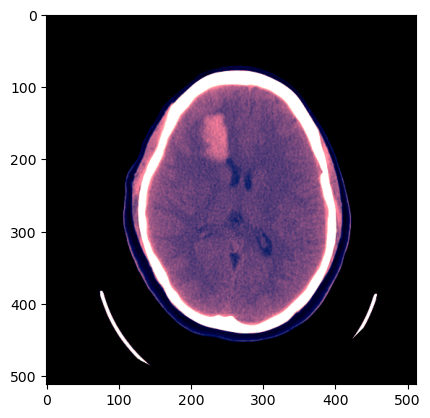

In [4]:
# Sanity Check
sample_dcm_fname = f'{TRAIN_DATA_PATH}/ID_1534bee18.dcm'
# with dataset_handler.open(sample_dcm_fname) as dcmf:
#     dcm = pydicom.dcmread(dcmf)
#     plt.imshow(bsb_window(dcm), cmap=plt.cm.bone)
dcm = pydicom.dcmread(sample_dcm_fname)
plt.imshow(bsb_window(dcm), cmap=plt.cm.bone)

In [5]:
def _read(path, desired_size):
    """Will be used in DataGenerator"""
    # with dataset_handler.open(path) as dcmf:
    try:
        dcm = pydicom.dcmread(path)
        img = bsb_window(dcm)
    except:
        img = np.zeros(desired_size, dtype=np.float32)
        
    img = cv2.resize(img, desired_size[:2], interpolation=cv2.INTER_LINEAR)
    
    return img

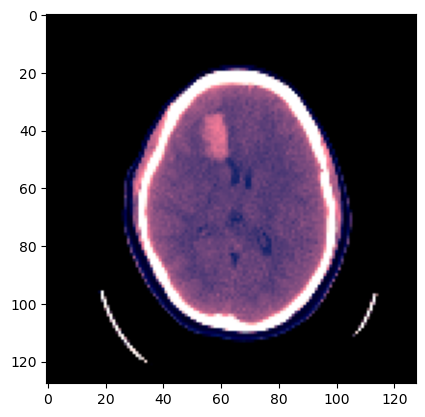

In [6]:
# Another sanity check
plt.imshow(_read(sample_dcm_fname, (128, 128)), cmap=plt.cm.bone)

In [ ]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, list_IDs, labels=None, batch_size=1, img_size=(512, 512, 1), img_dir=TRAIN_DATA_PATH, *args, **kwargs):
        super().__init__(**kwargs)
        self.list_IDs = list_IDs
        self.labels = labels
        self.batch_size = batch_size
        self.img_size = img_size
        self.img_dir = img_dir
        self.on_epoch_end()
    
    def __len__(self):
        return int(ceil(len(self.indices) / self.batch_size))
    
    def __getitem__(self, index):
        indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        list_IDs_temp = [self.list_IDs[k] for k in indices]
        
        if self.labels is not None:
            X, y = self.__data_generation(list_IDs_temp)
            return X,y
        else:
            X = self.__data_generation(list_IDs_temp)
            return X
        
    def on_epoch_end(self):
        if self.labels is not None:
            # keep probability of any=0 and any=1
            keep_prob = self.labels.iloc[:, 0].map({0: 0.35, 1: 0.5})
            keep = (keep_prob > np.random.rand(len(keep_prob)))
            self.indices = np.arange(len(self.list_IDs))[keep]
            np.random.shuffle(self.indices)
        else:
            self.indices =  np.arange(len(self.list_IDs))
            
    def __data_generation(self, list_IDs_temp):
        X = np.empty((self.batch_size, *self.img_size))
        # X = np.zeros((len(list_IDs_temp), *self.img_size), dtype=np.float32)
        
        if self.labels is not None: # training phase
            y = np.empty((self.batch_size, 6), dtype=np.float32)
            
            for i, ID in enumerate(list_IDs_temp):
                dcmf = os.path.join(self.img_dir, f'{ID}.dcm')
                X[i,] = _read(dcmf, self.img_size)
                y[i,] = self.labels.loc[ID].values
                
            return X,y
        else: # test phase
            for i, ID in enumerate(list_IDs_temp):
                dcmf = os.path.join(self.img_dir, f'{ID}.dcm')
                X[i, ] = _read(dcmf, self.img_size)
                
            return X

In [8]:
class_weights_c = tf.constant([2.0, 1.0, 1.0, 1.0, 1.0, 1.0], dtype=tf.float32)

I0000 00:00:1732029531.455138   69428 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8225 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB MIG 1g.10gb, pci bus id: 0000:07:00.0, compute capability: 8.0


In [9]:
def weighted_log_loss(y_true, y_pred):
    """
    Can be used as the loss function in model.compile()
    ---------------------------------------------------
    """
    
    class_weights = np.array([2., 1., 1., 1., 1., 1.])
    
    eps = K.epsilon()
    
    y_pred = K.clip(y_pred, eps, 1.0-eps)

    out = -(y_true  * K.log(y_pred) * class_weights + (1.0 - y_true) * K.log(1.0 - y_pred) * class_weights)
    
    return K.mean(out, axis=-1)

def _normalized_weighted_average(arr, weights=None):
    """
    A simple Keras implementation that mimics that of numpy.average()
    """
    
    if weights is not None:
        scl = K.sum(weights)
        weights = K.expand_dims(weights, axis=1)
        return K.sum(K.dot(arr, weights), axis=1) / scl
    return K.mean(arr, axis=1)

def weighted_loss(y_true, y_pred):
    """
    Will be used as the metric in model.compile()
    ---------------------------------------------
    
    Similar to the custom loss function 'weighted_log_loss()'
    but with normalized weights, which should be very similar 
    to the official competition metric:
        https://www.kaggle.com/kambarakun/lb-probe-weights-n-of-positives-scoring
    and hence:
        sklearn.metrics.log_loss with sample weights
    """
    
    class_weights = class_weights_c
    
    eps = K.epsilon()
    
    y_pred = K.clip(y_pred, eps, 1.0-eps)

    loss = -(y_true  * K.log(y_pred) + (1.0 - y_true) * K.log(1.0 - y_pred))
    
    loss_samples = _normalized_weighted_average(loss, class_weights)
    
    return K.mean(loss_samples)

def weighted_log_loss_metric(trues, preds):
    """
    Will be used to calculate the log loss 
    of the validation set in PredictionCheckpoint()
    ------------------------------------------
    """
    class_weights = [2., 1., 1., 1., 1., 1.]
    
    epsilon = 1e-7
    
    preds = np.clip(preds, epsilon, 1-epsilon)
    loss = trues * np.log(preds) + (1 - trues) * np.log(1 - preds)
    loss_samples = np.average(loss, axis=1, weights=class_weights)

    return - loss_samples.mean()

In [ ]:
class PredictionCheckpoint(keras.callbacks.Callback):
    def __init__(self, test_df, valid_df, test_images_dir=TEST_DATA_PATH, valid_images_dir=TRAIN_DATA_PATH, batch_size=32, input_size=(224, 224, 3)):
        self.test_df = test_df
        self.valid_df = valid_df
        self.test_images_dir = test_images_dir
        self.valid_images_dir = valid_images_dir
        self.batch_size = batch_size
        self.input_size = input_size
    
    def on_train_begin(self, logs={}):
        self.test_predictions = []
        self.valid_predictions = []
        
    def on_epoch_end(self, batch, logs={}):
        pass
        # test_generator = DataGenerator(self.test_df.index, None, self.batch_size, self.input_size, self.test_images_dir)
        # self.test_predictions.append(
        #     self.model.predict(
        #         test_generator,
        #         verbose=2,
        #         batch_size=self.batch_size
        #     )[:len(self.test_df)]
        # )
        
        # valid_generator = DataGenerator(self.valid_df.index, None, self.batch_size, self.input_size, self.valid_images_dir)
        # self.valid_predictions.append(
        #     self.model.predict(
        #         valid_generator,
        #         verbose=2
        #     )[:len(self.valid_df)]
        # )
        # self.test_predictions.append(
        #     self.model.predict_generator(
        #         DataGenerator(self.test_df.index, None, self.batch_size, self.input_size, self.test_images_dir),
        #         verbose=2
        #     )[:len(self.test_df)]
        # )
        
        # self.valid_predictions.append(
        #     self.model.predict_generator(
        #         DataGenerator(self.valid_df.index, None, self.batch_size, self.input_size, self.valid_images_dir),
        #         verbose=2
        #     )[:len(self.valid_df)]
        # )
        
        # print("validation loss: %.4f" % weighted_log_loss_metric(self.valid_df.values, np.average(self.valid_predictions, axis=0, weights=[2**i for i in range(len(self.valid_predictions))])))

In [11]:
class DeepModel:
    def __init__(self, engine, input_dims, batch_size=5, num_epochs=4, learning_rate=1e-3, decay_rate=1.0, decay_steps=1, weights='imagenet', verbose=1):
        self.engine = engine
        self.input_dims = input_dims
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        self.learning_rate = learning_rate
        self.decay_rate = decay_rate
        self.decay_steps = decay_steps
        self.weights = weights
        self.verbose = verbose
        self._build()
        
    def _build(self):
        engine = self.engine(include_top=False, weights=self.weights, input_shape=self.input_dims,backend = keras.backend, layers = keras.layers, models = keras.models, utils = keras.utils)
        
        x = keras.layers.GlobalAveragePooling2D(name='avg_pool')(engine.output)
        # x = keras.layers.Dropout(0.2)(x)
        # x = keras.layers.Dense(keras.backend.int_shape(x)[1], activation="relu", name="dense_hidden_1")(x)
        # x = keras.layers.Dropout(0.1)(x)
        out = keras.layers.Dense(6, activation='sigmoid', name='dense_output')(x)
        
        self.model = keras.models.Model(inputs=engine.input, outputs=out)
        
        self.model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(), metrics=[weighted_loss])
        
    def fit_and_predict(self, train_df, valid_df, test_df):
        # Callbacks
        pred_history = PredictionCheckpoint(test_df, valid_df, input_size=self.input_dims)
        #checkpointer = keras.callbacks.ModelCheckpoint(filepath='%s-{epoch:02d}.hdf5' % self.engine.__name__, verbose=1, save_weights_only=True, save_best_only=False)
        scheduler = keras.callbacks.LearningRateScheduler(lambda epoch: self.learning_rate * pow(self.decay_rate, floor(epoch / self.decay_steps)))
        
        train_data_generator = DataGenerator(train_df.index, train_df, self.batch_size, self.input_dims, TRAIN_DATA_PATH, workers=4, use_multiprocessing=True)
        # deprecated
        # self.model.fit_generator(
        #     train_data_generator,
        #     epochs=self.num_epochs,
        #     verbose=self.verbose,
        #     use_multiprocessing=True,
        #     workers=4,
        #     callbacks=[pred_history, scheduler]
        # )
        self.model.fit(
            train_data_generator,
            epochs=self.num_epochs,
            verbose=self.verbose,
            # use_multiprocessing=True,
            # workers=4,
            callbacks=[pred_history, scheduler]
        )
        
        return pred_history
    
    def save(self, path):
        self.model.save_weights(path)
        
    def load(self, path):
        self.model.load_weights(path)
        

In [12]:
def read_testset(filename=TEST_METADATA_PATH):
    csv_file = filename# dataset_handler.open(filename)
    df = pd.read_csv(csv_file)
    # csv_file.close()
    
    df['Image'] = df['ID'].str.slice(stop=12)
    df['Diagnosis'] = df['ID'].str.slice(start=13)
    
    df = df.loc[:, ['Label', 'Diagnosis', 'Image']]
    df = df.set_index(['Image', 'Diagnosis']).unstack(level=-1)
    
    return df

def read_trainset(filename=TRAIN_METADATA_PATH):
    csv_file = filename #dataset_handler.open(filename)
    df = pd.read_csv(csv_file)
    # csv_file.close()
    
    df["Image"] = df["ID"].str.slice(stop=12)
    df["Diagnosis"] = df["ID"].str.slice(start=13)
    
    duplicates_to_remove = [
        56346, 56347, 56348, 56349,
        56350, 56351, 1171830, 1171831,
        1171832, 1171833, 1171834, 1171835,
        3705312, 3705313, 3705314, 3705315,
        3705316, 3705317, 3842478, 3842479,
        3842480, 3842481, 3842482, 3842483
    ]
    
    df = df.drop(index=duplicates_to_remove)
    df = df.reset_index(drop=True)
    
    df = df.loc[:, ['Label', 'Diagnosis', 'Image']]
    df = df.set_index(['Image', 'Diagnosis']).unstack(level=-1)
    
    return df

In [13]:
test_df = read_testset()
df = read_trainset()

In [14]:
df = df.sample(n=floor(len(df)*0.1), random_state=42)
test_df = test_df.sample(n=floor(len(test_df)*0.1), random_state=42)

In [18]:
gen = DataGenerator(df.index, df, 5, (512, 512, 3))
batch = next(iter(gen))
x, y = batch
print(x.dtype, y.dtype)

float32 float32


In [21]:
y.shape

(5, 6)

In [ ]:
# train set (90%) and validation set (10%)
ss = ShuffleSplit(n_splits=10, test_size=0.1, random_state=42).split(df.index)

# lets go for first fold only
train_idx, valid_idx = next(ss)

# # # obtain model
model = DeepModel(engine=InceptionV3, input_dims=(256, 256, 3), batch_size=8, learning_rate=5e-4, num_epochs=5, decay_rate=0.8, decay_steps=1, weights='imagenet', verbose=1)

# # # obtain test + validation predictions (history.test_predictions, history.valid_predictions)
history = model.fit_and_predict(df.iloc[train_idx], df.iloc[valid_idx], test_df)

Epoch 1/5


I0000 00:00:1732029630.603837   69984 service.cc:148] XLA service 0x7ef2f0002080 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732029630.603900   69984 service.cc:156]   StreamExecutor device (0): NVIDIA A100-SXM4-40GB MIG 1g.10gb, Compute Capability 8.0
2024-11-19 15:20:31.513599: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1732029634.953880   69984 cuda_dnn.cc:529] Loaded cuDNN version 90300
2024-11-19 15:20:36.959803: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_22717_0', 8 bytes spill stores, 8 bytes spill loads



   1/3140 ━━━━━━━━━━━━━━━━━━━━ 69:59:25 80s/step - loss: 0.7687 - weighted_loss: 0.7515

I0000 00:00:1732029667.082836   69984 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3140/3140 ━━━━━━━━━━━━━━━━━━━━ 288s 66ms/step - loss: 0.2141 - weighted_loss: 0.2398 - learning_rate: 5.0000e-04
Epoch 2/5
3140/3140 ━━━━━━━━━━━━━━━━━━━━ 202s 64ms/step - loss: 0.1789 - weighted_loss: 0.1990 - learning_rate: 4.0000e-04
Epoch 3/5
3140/3140 ━━━━━━━━━━━━━━━━━━━━ 199s 63ms/step - loss: 0.1424 - weighted_loss: 0.1569 - learning_rate: 2.5600e-04
Epoch 5/5
3140/3140 ━━━━━━━━━━━━━━━━━━━━ 216s 69ms/step - loss: 0.1307 - weighted_loss: 0.1437 - learning_rate: 2.0480e-04
